Training Progress: 100%|███████████████████| 5000/5000 [18:46<00:00,  4.44it/s, Mean Reward=1.33e+3]


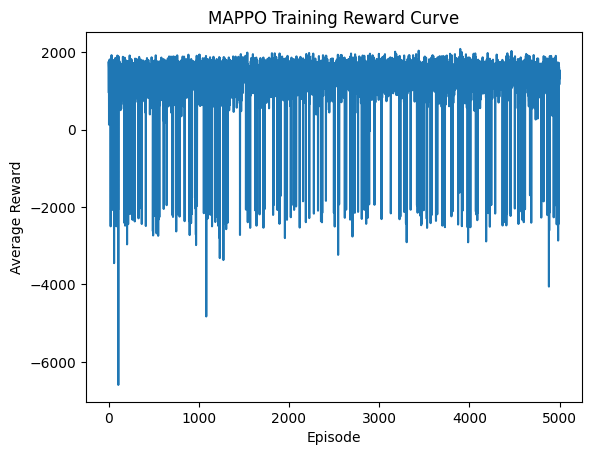

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from torch.distributions import Categorical
from pettingzoo import ParallelEnv
from gym import spaces
import random
from env_new.MAenv import CustomMAEnvironment
from tqdm import tqdm

# 创建环境
env = CustomMAEnvironment()


class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)


class ValueNetwork(nn.Module):
    def __init__(self, input_dim):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)


class MAPPOAgent:
    def __init__(self, input_dim, action_dim, epsilon=0.2, gamma=0.99, tau=0.95, lr=3e-4):
        self.input_dim = input_dim
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma
        self.tau = tau
        self.lr = lr
        
        # 初始化策略网络和价值网络
        self.policy_net = PolicyNetwork(input_dim, action_dim)
        self.value_net = ValueNetwork(input_dim)
        
        # 为了存储旧的log_probs
        self.old_log_probs = None

        self.optimizer = torch.optim.Adam(
            list(self.policy_net.parameters()) + list(self.value_net.parameters()), lr=self.lr
        )

    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)  # 转换为Tensor并增加批次维度
        action_probs = self.policy_net(state)
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        
        # 保存当前的log_prob
        log_prob = dist.log_prob(action)
        
        # 保存old_log_probs
        self.old_log_probs = log_prob
        
        return action.item(), log_prob

    def update(self, trajectories):
        # 从轨迹中获取状态、动作、奖励、下一个状态等
        states = torch.FloatTensor([t[0] for t in trajectories])
        actions = torch.LongTensor([t[1] for t in trajectories])
        rewards = torch.FloatTensor([t[2] for t in trajectories])
        next_states = torch.FloatTensor([t[3] for t in trajectories])
        dones = torch.FloatTensor([t[4] for t in trajectories])
        
        # 计算当前状态的价值
        values = self.value_net(states)
        
        # 计算下一个状态的价值
        next_values = self.value_net(next_states)
        
        # 计算优势函数
        advantage = self.compute_advantage(rewards, values, next_values, dones)
        
        # 获取当前的log_probs（通过策略网络）
        action_probs = self.policy_net(states)
        dist = torch.distributions.Categorical(action_probs)
        log_probs = dist.log_prob(actions)
        
        # 计算ratio
        ratio = torch.exp(log_probs - self.old_log_probs)
        
        # PPO clip loss
        clip_loss = torch.min(ratio * advantage, torch.clamp(ratio, 1 - self.epsilon, 1 + self.epsilon) * advantage)
        
        # 计算总损失
        value_loss = (rewards - values).pow(2).mean()
        loss = -clip_loss.mean() + value_loss
        
        # 更新网络参数
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def compute_advantage(self, rewards, values, next_values, dones):
        # 计算优势函数：GAE算法
        deltas = rewards + self.gamma * next_values * (1 - dones) - values
        advantages = torch.zeros_like(deltas)
        last_gae_lam = 0
        for t in reversed(range(len(deltas))):
            advantages[t] = deltas[t] + self.gamma * self.tau * (1 - dones[t]) * last_gae_lam
            last_gae_lam = advantages[t]
        return advantages




def train(env, agents, num_episodes=5000):
    all_rewards = []

    # 用tqdm包装训练循环，显示训练进度
    progress_bar = tqdm(range(num_episodes), desc="Training Progress", ncols=100)

    for episode in progress_bar:
        # 重置环境
        observations = env.reset()
        total_reward = {agent: 0 for agent in env.agents}
        trajectories = {agent: [] for agent in env.agents}
        
        done = {agent: False for agent in env.agents}
        
        while not all(done.values()):
            actions = {}
            log_probs = {}
            
            # 为每个智能体获取动作和log_prob
            for agent in env.agents:
                agent_obj = agents[agent]  # 获取对应的MAPPOAgent对象
                obs = observations[agent]
                action, log_prob = agent_obj.get_action(obs)  # 获取动作
                actions[agent] = action
                log_probs[agent] = log_prob
                
            # 执行动作并获取新状态
            next_observations, rewards, done, infos = env.step(actions)
            
            # 记录轨迹
            for agent in env.agents:
                trajectories[agent].append((observations[agent], actions[agent], rewards[agent], next_observations[agent], done[agent]))
                total_reward[agent] += rewards[agent]
            
            # 更新观察值
            observations = next_observations
        
        # 训练每个智能体
        for agent in env.agents:
            agent_obj = agents[agent]
            agent_obj.update(trajectories[agent])

        # 记录每个episode的总奖励
        mean_reward = np.mean(list(total_reward.values()))
        all_rewards.append(mean_reward)
        
        # 每100个episode输出一次奖励信息，并更新进度条的描述
        if episode % 1 == 0:
            progress_bar.set_postfix({'Mean Reward': mean_reward}, refresh=True)

    return all_rewards




# 为每个智能体创建MAPPO代理
agents = {agent: MAPPOAgent(input_dim=env.state_dim, action_dim=env.action_space(agent).n) for agent in env.agents}

# 开始训练
reward_curve = train(env, agents)

# 绘制奖励变化曲线
plt.plot(reward_curve)
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.title("MAPPO Training Reward Curve")
plt.show()
